In [1]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import datetime

sys.path.append('/lib')
sys.path.append('/data')
import lib.helper as helper

%matplotlib inline

WORKSHOP_TYPES = ["SWC", "DC", "LC", "TTT", "Circuits"]
STOPPED_WORKSHOP_TYPES = ['stalled', 'cancelled', 'unresponsive']

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
PROCESSED_DATA_DIR = DATA_DIR + '/processed'

In [2]:
# Absolute or relative path to workshop data extracted from Carpentries Redash
workshops_file = "/Users/alex/Desktop/workshops_UK_2020_02_18.csv"

In [3]:
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")
workshops_df

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,"LC,cancelled"
4,2015-11-09-cul,NaN,NaN,GB,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,LC
5,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,-0.629225,52.074389,2014-07-21,2014-07-23,28,Cranfield University,cranfield.ac.uk,GB,SWC
6,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,-1.228790,51.657608,2015-11-09,2015-11-10,43,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,SWC
7,2019-05-29-elixir-nottingham,University of Nottingham,"The University of Nottingham, Teaching and Lea...",GB,-1.194670,52.934502,2019-05-29,2019-05-30,0,ELIXIR-UK,elixir-uk.org,GB,SWC
8,2016-10-18-EI,Earlham Institute - Darwin Room,"Norwich Research Park, Norwich, NR4 7UG",GB,1.219461,52.621793,2016-10-18,2016-10-19,15,Earlham Institute,earlham.ac.uk,GB,DC
9,2017-11-21-EI,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ",GB,1.219461,52.621793,2017-11-21,2017-11-22,15,Earlham Institute,earlham.ac.uk,GB,DC


In [4]:
# Convert column "tags" from a string to a list of strings
idx = workshops_df.columns.get_loc("tags")
workshops_df.insert(loc=idx, column='tags_list', value=workshops_df["tags"])
workshops_df["tags_list"] = workshops_df["tags"].str.split(',')

In [5]:
workshops_df.tags_list[3]

['LC', 'cancelled']

In [6]:
# Extract workshop type ('SWC', 'DC', 'LC', 'Circuits', 'TTT') and status ('cancelled', 'unresponsive', 'stalled', "Pilot") 
# and add as a new column
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_type',
                            value=workshops_df["tags_list"])
workshops_df["workshop_type"] = workshops_df["tags_list"].map(helper.extract_workshop_type, na_action="ignore")
workshops_df

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,DC,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC,[SWC],SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits,[Circuits],Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,LC,"[LC, cancelled]","LC,cancelled"
4,2015-11-09-cul,NaN,NaN,GB,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,LC,[LC],LC
5,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,-0.629225,52.074389,2014-07-21,2014-07-23,28,Cranfield University,cranfield.ac.uk,GB,SWC,[SWC],SWC
6,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,-1.228790,51.657608,2015-11-09,2015-11-10,43,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,SWC,[SWC],SWC
7,2019-05-29-elixir-nottingham,University of Nottingham,"The University of Nottingham, Teaching and Lea...",GB,-1.194670,52.934502,2019-05-29,2019-05-30,0,ELIXIR-UK,elixir-uk.org,GB,SWC,[SWC],SWC
8,2016-10-18-EI,Earlham Institute - Darwin Room,"Norwich Research Park, Norwich, NR4 7UG",GB,1.219461,52.621793,2016-10-18,2016-10-19,15,Earlham Institute,earlham.ac.uk,GB,DC,[DC],DC
9,2017-11-21-EI,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ",GB,1.219461,52.621793,2017-11-21,2017-11-22,15,Earlham Institute,earlham.ac.uk,GB,DC,[DC],DC


In [20]:
# How many workshops that do not have a workshop type?
print(workshops_df[workshops_df['workshop_type']==""][["slug", "tags_list"]])
print(workshops_df[workshops_df['workshop_type']==""]['workshop_type'].count())

                       slug       tags_list
12            2018-10-02-DC     [cancelled]
60   2016-04-26-london-nrgi       [stalled]
72        2017-02-13-oxford     [cancelled]
109       2017-04-27-london     [cancelled]
134         2018-01-xx-bath       [stalled]
147  2018-09-xx-bradford-dc     [cancelled]
168       2018-09-05-dundee     [cancelled]
218        2016-09-14-leeds     [cancelled]
237     2017-01-xx-bradford       [stalled]
270       2016-11-14-oxford       [stalled]
309      2018-06-xx-glasgow  [unresponsive]
11
Empty DataFrame
Columns: [slug, tags_list]
Index: []


In [8]:
# Extract 'stopped' workshop status, normally ('cancelled', 'unresponsive', 'stalled'), and separate from the workshop's type
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_status',
                            value=workshops_df["tags_list"])
workshops_df["workshop_status"] = workshops_df["tags_list"].map(helper.extract_workshop_status, na_action="ignore")

In [22]:
# How many workshops that do not have a status?
print(workshops_df[workshops_df['workshop_status']==""][["slug", "workshop_type", "tags"]])
print(workshops_df[workshops_df['workshop_status']==""]['workshop_status'].count())

print("Total workshops: " + str(len(workshops_df.index)))

                                 slug workshop_type      tags
0                  2019-10-29-cardiff            DC        DC
1                   2020-02-10-turing           SWC       SWC
2                2020-02-20-lancaster      Circuits  Circuits
4                      2015-11-09-cul            LC        LC
5                2014-07-21-cranfield           SWC       SWC
6                   2015-11-09-culham           SWC       SWC
7        2019-05-29-elixir-nottingham           SWC       SWC
8                       2016-10-18-EI            DC        DC
9                       2017-11-21-EI            DC        DC
10                 2017-10-10-norwich           SWC       SWC
11                 2017-04-26-norwich           SWC       SWC
13   2019-01-22-earlham-institute-swc           SWC       SWC
14                     2019-01-22-SWC           SWC       SWC
15                 2019-03-05-earlham            DC        DC
16                 2020-01-21-earlham           SWC       SWC
17      

In [17]:
# How many "stopped" workshops are there?
workshops_df[(workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]['workshop_status'].value_counts()

stalled         8
cancelled       8
unresponsive    3
Name: workshop_status, dtype: int64

In [170]:
# How many "Circuits" workshops are there?
workshops_df[workshops_df['workshop_type'] == 'Circuits']

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020.0,2020-02-21,...,CCP CoDiMa,codima.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
59,2019-11-15-edinburgh-library-carpentry,University of Edinburgh,"Digital Scholarship Centre, Floor 6, Universit...",GB,United Kingdom,Scotland,-3.188267,55.953251,2019.0,2019-11-15,...,National Library of Scotland,nls.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
131,2019-11-19-aberystwyth,Aberystwyth University,"Old College, King Street",GB,United Kingdom,Wales,-4.088170,52.414590,2019.0,2019-11-19,...,University of Aberystwyth,aber.ac.uk,GB,Wales,PRIFYSGOL ABERYSTWYTH,PRIFYSGOL ABERYSTWYTH,Circuits,,[Circuits],Circuits
132,2019-11-06-aberystwyth,Aberystwyth University,G24 Cledwyn Building,GB,United Kingdom,Wales,-4.067130,52.417040,2019.0,2019-11-06,...,University of Aberystwyth,aber.ac.uk,GB,Wales,PRIFYSGOL ABERYSTWYTH,PRIFYSGOL ABERYSTWYTH,Circuits,,[Circuits],Circuits
198,2019-10-07-unixshell,"Medical Education Centre, Computing Lab","MEC, The Anne. Ferguson Building. WGH",GB,United Kingdom,Scotland,-3.234058,55.962345,2019.0,2019-10-07,...,University of Edinburgh,ed.ac.uk,GB,Scotland,UNIVERSITY OF EDINBURGH,UNIVERSITY OF EDINBURGH,Circuits,,[Circuits],Circuits
255,2019-12-11-durham,Library Carpentry NE England at Durham University,"Bill Bryson Library, Stockton Road, Durham, Du...",GB,United Kingdom,North East,-1.573079,54.768265,2019.0,2019-12-11,...,University of Manchester,manchester.ac.uk,GB,North West,THE UNIVERSITY OF MANCHESTER,THE UNIVERSITY OF MANCHESTER,Circuits,,[Circuits],Circuits
297,2019-11-19-southampton-swc,Astronomy & Astrophysics,"Seminar Room, Building 46",GB,United Kingdom,South East,-1.395950,50.934630,2019.0,2019-11-19,...,University of Southampton,southampton.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits


In [23]:
# How many workshops are missing country information?
workshops_df[workshops_df['country_code'] == ""]['country_code'].count()

0

In [24]:
# Insert countries where workshops were held based on country_code
idx = workshops_df.columns.get_loc("country_code")
workshops_df.insert(loc=idx + 1, column='country',
                            value=workshops_df["country_code"])
# workshops_df["country"] = workshops_df["country_code"].map(helper.get_country, na_action="ignore")
# workshops_df

countries = pd.read_csv("lib/country_codes.csv", encoding = "utf-8")
countries_mapping = dict(countries[['country_code', 'country_name']].values)
workshops_df['country'] = workshops_df['country_code'].map(countries_mapping, na_action="ignore")
workshops_df.head(10)

,slug,venue,address,country_code,country,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC,,[SWC],SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits,,[Circuits],Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,LC,cancelled,"[LC, cancelled]","LC,cancelled"
4,2015-11-09-cul,NaN,NaN,GB,United Kingdom,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,LC,,[LC],LC
5,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,United Kingdom,-0.629225,52.074389,2014-07-21,2014-07-23,28,Cranfield University,cranfield.ac.uk,GB,SWC,,[SWC],SWC
6,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,United Kingdom,-1.228790,51.657608,2015-11-09,2015-11-10,43,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,SWC,,[SWC],SWC
7,2019-05-29-elixir-nottingham,University of Nottingham,"The University of Nottingham, Teaching and Lea...",GB,United Kingdom,-1.194670,52.934502,2019-05-29,2019-05-30,0,ELIXIR-UK,elixir-uk.org,GB,SWC,,[SWC],SWC
8,2016-10-18-EI,Earlham Institute - Darwin Room,"Norwich Research Park, Norwich, NR4 7UG",GB,United Kingdom,1.219461,52.621793,2016-10-18,2016-10-19,15,Earlham Institute,earlham.ac.uk,GB,DC,,[DC],DC
9,2017-11-21-EI,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ",GB,United Kingdom,1.219461,52.621793,2017-11-21,2017-11-22,15,Earlham Institute,earlham.ac.uk,GB,DC,,[DC],DC


In [25]:
# Add UK region for a workshop based on its geocoordinates as a new column
idx = workshops_df.columns.get_loc("country")
workshops_df.insert(loc=idx + 1, column='region',
                            value=workshops_df["country_code"])
workshops_df['region'] = workshops_df.apply(lambda x: helper.get_uk_region(latitude=x['latitude'],
                                    longitude=x['longitude']), axis=1)
print("\n################################\nThis took a while but it has finished now")

Looking up region for geocoordinates: (51.49191, -3.1854299999999998)
Looking up region for geocoordinates: (51.5302, -0.1271)
Looking up region for geocoordinates: (54.01212099999999, 2.789279)
Could no find UK region for location (54.01212099999999, 2.789279)
Looking up region for geocoordinates: (nan, nan)
Could no find UK region for location (nan, nan)
Looking up region for geocoordinates: (51.5280395, -0.1015937)
Looking up region for geocoordinates: (52.074389000000004, -0.629225)
Looking up region for geocoordinates: (51.6576076, -1.2287899)
Looking up region for geocoordinates: (52.934502, -1.1946700000000001)
Looking up region for geocoordinates: (52.621793000000004, 1.2194610000000001)
Looking up region for geocoordinates: (52.621793000000004, 1.2194610000000001)
Looking up region for geocoordinates: (52.621741, 1.218987)
Looking up region for geocoordinates: (52.621741, 1.218987)
Looking up region for geocoordinates: (52.621741, 1.218987)
Looking up region for geocoordinates

In [26]:
# Add UK region for a workshop based on its organiser (lookup UK academic institutitons and HESA data) as a new column
uk_academic_institutions = pd.read_csv("lib/UK-academic-institutions.csv", encoding = "utf-8")
hesa_UK_higher_education_providers = pd.read_csv("lib/HESA_UK_higher_education_providers.csv", encoding = "utf-8")
hesa_UK_higher_education_providers_region_mapping = dict(hesa_UK_higher_education_providers[['UKPRN', 'Region']].values) # create a dict for lookup

uk_academic_institutions['domain'] = uk_academic_institutions['WEBSITE_URL'].apply(lambda x: x.strip("http://www.").strip("/")) # strip 'http://www' from domain
uk_academic_institutions['region'] = uk_academic_institutions['UKPRN'].map(hesa_UK_higher_education_providers_region_mapping, na_action="ignore")
print(uk_academic_institutions)

uk_academic_institutions_region_mapping = dict(uk_academic_institutions[['domain', 'region']].values) # create a dict for lookup

idx = workshops_df.columns.get_loc("organiser_country_code")
workshops_df.insert(loc=idx + 1, column='organiser_region', value=workshops_df["organiser_domain"])
workshops_df['organiser_region'] = workshops_df['organiser_region'].map(uk_academic_institutions_region_mapping,na_action="ignore")
workshops_df.head(5)

        UKPRN                                      PROVIDER_NAME  \
0    10008640                                FALMOUTH UNIVERSITY   
1    10007774                               UNIVERSITY OF OXFORD   
2    10007768                            UNIVERSITY OF LANCASTER   
3    10000571                                BATH SPA UNIVERSITY   
4    10007814                                 CARDIFF UNIVERSITY   
5    10007158                          UNIVERSITY OF SOUTHAMPTON   
6    10007779                       THE ROYAL VETERINARY COLLEGE   
7    10007851                                UNIVERSITY OF DERBY   
8    10000824                             BOURNEMOUTH UNIVERSITY   
9    10007162                     UNIVERSITY OF THE ARTS, LONDON   
10   10007804                             UNIVERSITY OF STIRLING   
11   10007823                               EDGE HILL UNIVERSITY   
12   10007160                               UNIVERSITY OF SURREY   
13   10007791                                UNI

,slug,venue,address,country_code,country,region,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,NaN,SWC,,[SWC],SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,NaN,Circuits,,[Circuits],Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
4,2015-11-09-cul,NaN,NaN,GB,United Kingdom,London,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,London,LC,,[LC],LC


In [28]:
print(workshops_df.columns)
workshops_df[workshops_df['region'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'workshop_type', 'workshop_status', 'tags_list', 'tags'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,NaN,Circuits,,[Circuits],Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
13,2019-01-22-earlham-institute-swc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2019-01-22,2019-01-23,18,Earlham Institute,earlham.ac.uk,GB,NaN,SWC,,[SWC],SWC
24,2019-06-26-heriotwatt,Heriot Watt University (Riccarton campus),TBD,GB,United Kingdom,None,NaN,NaN,2019-06-26,2019-06-27,21,Heriot Watt University,hw.ac.uk,GB,NaN,DC,,[DC],DC
48,2018-03-xx-london,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,King's College London,kcl.ac.uk,GB,London,SWC,stalled,"[SWC, stalled]","SWC,stalled"
60,2016-04-26-london-nrgi,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2016-04-26,2016-04-27,0,Natural Resource Governance Institute,resourcegovernance.org,GB,NaN,,stalled,[stalled],stalled
68,2019-06-xx-location,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,SSI Software Sustainability Institute,software.ac.uk,GB,NaN,LC,,[LC],LC
78,2018-11-08-swansea,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2018-11-08,2018-11-09,0,Swansea University,swansea.ac.uk,GB,NaN,SWC,,[SWC],SWC
80,2019-02-20-swansea,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2019-02-20,2019-02-21,0,Swansea University,swansea.ac.uk,GB,NaN,DC,,[DC],DC
109,2017-04-27-london,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2017-04-27,2017-04-28,0,University College London,ucl.ac.uk,GB,London,,cancelled,[cancelled],cancelled


In [29]:
# Let's get normalised and common names for UK academic instituions, if exist, by mapping to UK higher education providers
uk_academic_institutions_normalised_names_mapping = dict(uk_academic_institutions[['domain', 'PROVIDER_NAME']].values) # create a dict for lookup
uk_academic_institutions_common_mapping = dict(uk_academic_institutions[['domain', 'VIEW_NAME']].values) # create a dict for lookup

# Insert normalised (official) name for organiser 
workshops_df.insert(loc=idx + 2, column='organiser_normalised_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_normalised_name'] = workshops_df['organiser_normalised_name'].map(uk_academic_institutions_normalised_names_mapping,na_action="ignore")

# Insert common name for organiser
workshops_df.insert(loc=idx + 3, column='organiser_common_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_common_name'] = workshops_df['organiser_common_name'].map(uk_academic_institutions_normalised_names_mapping,na_action="ignore")


In [30]:
print(workshops_df.columns)
workshops_df[workshops_df['organiser_common_name'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'organiser_normalised_name', 'organiser_common_name', 'workshop_type',
       'workshop_status', 'tags_list', 'tags'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019-10-29,2019-10-30,...,ARCHER,archer.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020-02-10,2020-02-11,...,Alan Turing Institute,turing.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,...,CCP CoDiMa,codima.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
3,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,"CILIP, library and information association",cilip.org.uk,GB,NaN,NaN,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
6,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,United Kingdom,South East,-1.228790,51.657608,2015-11-09,2015-11-10,...,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
7,2019-05-29-elixir-nottingham,University of Nottingham,"The University of Nottingham, Teaching and Lea...",GB,United Kingdom,East Midlands,-1.194670,52.934502,2019-05-29,2019-05-30,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
8,2016-10-18-EI,Earlham Institute - Darwin Room,"Norwich Research Park, Norwich, NR4 7UG",GB,United Kingdom,Eastern,1.219461,52.621793,2016-10-18,2016-10-19,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
9,2017-11-21-EI,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ",GB,United Kingdom,Eastern,1.219461,52.621793,2017-11-21,2017-11-22,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
10,2017-10-10-norwich,Earlham Institute,"Darwin Room, Norwich Research Park, Norwich, N...",GB,United Kingdom,Eastern,1.218987,52.621741,2017-10-10,2017-10-11,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
11,2017-04-26-norwich,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ, Unite...",GB,United Kingdom,Eastern,1.218987,52.621741,2017-04-26,2017-04-27,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC


In [31]:
# Extract workshop year from its slug and add as a new column
# workshops_df.drop(['year'], axis=1)
idx = workshops_df.columns.get_loc("start")
workshops_df.insert(loc=idx, column='year', value=workshops_df["start"])
workshops_df["year"] = workshops_df["start"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d").year,
                                                 na_action="ignore")
workshops_df[workshops_df['year'].isnull()]

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
3,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,"CILIP, library and information association",cilip.org.uk,GB,NaN,NaN,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
48,2018-03-xx-london,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,King's College London,kcl.ac.uk,GB,London,KING'S COLLEGE LONDON,KING'S COLLEGE LONDON,SWC,stalled,"[SWC, stalled]","SWC,stalled"
68,2019-06-xx-location,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,SSI Software Sustainability Institute,software.ac.uk,GB,NaN,NaN,NaN,LC,,[LC],LC
127,2018-03-xx-aberystwyth,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Aberystwyth,aber.ac.uk,GB,Wales,PRIFYSGOL ABERYSTWYTH,PRIFYSGOL ABERYSTWYTH,SWC,stalled,"[SWC, stalled]","SWC,stalled"
135,2017-11-xx-birmingham,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Birmingham,bham.ac.uk,GB,NaN,NaN,NaN,SWC,stalled,"[SWC, stalled]","SWC,stalled"
146,2017-xx-xx-bradford,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Bradford,bradford.ac.uk,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,DC,stalled,"[DC, stalled]","DC,stalled"
147,2018-09-xx-bradford-dc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Bradford,bradford.ac.uk,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,,cancelled,[cancelled],cancelled
237,2017-01-xx-bradford,"J.B. Priestley - Floor 01, Room 01.53","University of Bradford, BF7 1DP, UK",GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Manchester,manchester.ac.uk,GB,North West,THE UNIVERSITY OF MANCHESTER,THE UNIVERSITY OF MANCHESTER,,stalled,[stalled],stalled
303,2018-11-xx-st-andrews-swc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of St. Andrews,st-andrews.ac.uk,GB,Scotland,UNIVERSITY OF ST ANDREWS,UNIVERSITY OF ST ANDREWS,SWC,,[SWC],SWC
309,2018-06-xx-glasgow,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Strathclyde,strath.ac.uk,GB,Scotland,UNIVERSITY OF STRATHCLYDE,UNIVERSITY OF STRATHCLYDE,,unresponsive,[unresponsive],unresponsive


In [32]:
# Save all the processed workshop data into a separate CSV file, in the case we need to look into it later
processed_data_file = PROCESSED_DATA_DIR + "/processed_" + os.path.basename(workshops_file)
workshops_df.to_csv(processed_data_file, encoding = "utf-8")
print("Saved processed Carpentry workshop data to "+ processed_data_file)

Saved processed Carpentry workshop data to /Users/alex/work/SSI/Code/carpentry-workshops-instructors-extractor/data/processed/processed_workshops_UK_2020_02_18.csv


In [33]:
# Now get rid of all "stalled", "cancelled" and "unresponsive" workshops for further analyses
workshops_df = workshops_df[(~workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]
workshops_df

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019.0,2019-10-29,...,ARCHER,archer.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020.0,2020-02-10,...,Alan Turing Institute,turing.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
2,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020.0,2020-02-21,...,CCP CoDiMa,codima.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
4,2015-11-09-cul,NaN,NaN,GB,United Kingdom,London,-0.101594,51.528039,2015.0,2015-11-09,...,"City, University of London",city.ac.uk,GB,London,THE CITY UNIVERSITY,THE CITY UNIVERSITY,LC,,[LC],LC
5,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,United Kingdom,Eastern,-0.629225,52.074389,2014.0,2014-07-21,...,Cranfield University,cranfield.ac.uk,GB,East of England,CRANFIELD UNIVERSITY,CRANFIELD UNIVERSITY,SWC,,[SWC],SWC
6,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,United Kingdom,South East,-1.228790,51.657608,2015.0,2015-11-09,...,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
7,2019-05-29-elixir-nottingham,University of Nottingham,"The University of Nottingham, Teaching and Lea...",GB,United Kingdom,East Midlands,-1.194670,52.934502,2019.0,2019-05-29,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
8,2016-10-18-EI,Earlham Institute - Darwin Room,"Norwich Research Park, Norwich, NR4 7UG",GB,United Kingdom,Eastern,1.219461,52.621793,2016.0,2016-10-18,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
9,2017-11-21-EI,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ",GB,United Kingdom,Eastern,1.219461,52.621793,2017.0,2017-11-21,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
10,2017-10-10-norwich,Earlham Institute,"Darwin Room, Norwich Research Park, Norwich, N...",GB,United Kingdom,Eastern,1.218987,52.621741,2017.0,2017-10-10,...,Earlham Institute,earlham.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC


float64
float64
Float64Index([2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0,
              2020.0],
             dtype='float64', name='year')
        number_of_workshops
year                       
2012.0                    7
2013.0                   14
2014.0                   20
2015.0                   31
2016.0                   39
2017.0                   51
2018.0                   55
2019.0                   68
2020.0                    9


/Users/alex/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


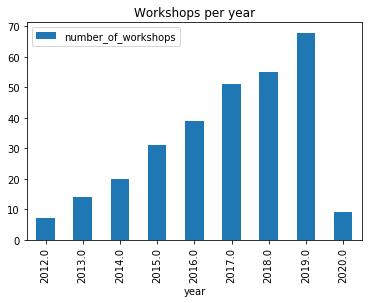

In [147]:
# How many workshops are there for each year?
workshops_df['year'] = workshops_df['year'].round()
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
print(workshops_per_year.index.dtype)
workshops_per_year.index.astype(int)
print(workshops_per_year.index.dtype)
print(workshops_per_year.index)
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

               number_of_workshops
workshop_type                     
SWC                            217
DC                              51
TTT                             15
Circuits                         7
LC                               6


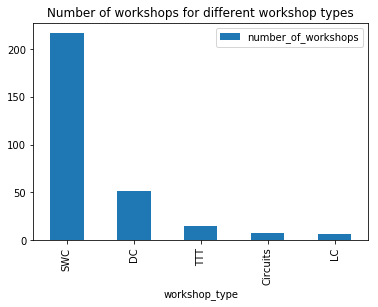

In [54]:
# How many SWC, DC, LC, TTT workshops were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

workshop_type  Circuits  DC  LC  SWC  TTT
year                                     
2012                  0   0   0    7    0
2013                  0   0   0   14    0
2014                  0   0   0   20    0
2015                  0   2   1   24    4
2016                  0   7   0   29    3
2017                  0  12   2   33    4
2018                  0  10   2   42    1
2019                  6  19   0   40    3
2020                  1   1   0    7    0


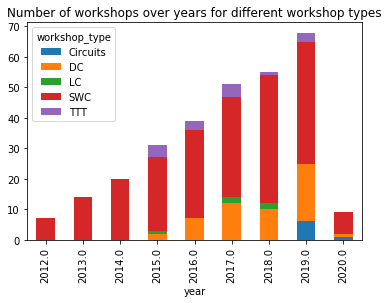

In [55]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

In [ ]:
print(workshops_per_type_per_year.columns)

ucl.ac.uk            33
manchester.ac.uk     31
ed.ac.uk             31
imperial.ac.uk       22
leeds.ac.uk          18
ox.ac.uk             14
southampton.ac.uk    14
st-andrews.ac.uk     11
cam.ac.uk            11
bham.ac.uk           10
swansea.ac.uk         9
earlham.ac.uk         9
kcl.ac.uk             7
aber.ac.uk            5
anthro.ox.ac.uk       4
bristol.ac.uk         4
dundee.ac.uk          4
epcc.ed.ac.uk         3
shef.ac.uk            3
qmul.ac.uk            3
tgac.ac.uk            3
crick.ac.uk           2
york.ac.uk            2
nhm.ac.uk             2
ncl.ac.uk             2
exeter.ac.uk          2
software.ac.uk        2
qub.ac.uk             2
rhul.ac.uk            2
hw.ac.uk              2
nottingham.ac.uk      2
gla.ac.uk             2
nls.uk                1
egi.eu                1
supa.ac.uk            1
codima.ac.uk          1
hud.ac.uk             1
ccfe.ac.uk            1
city.ac.uk            1
liv.ac.uk             1
self-organized        1
port.ac.uk      

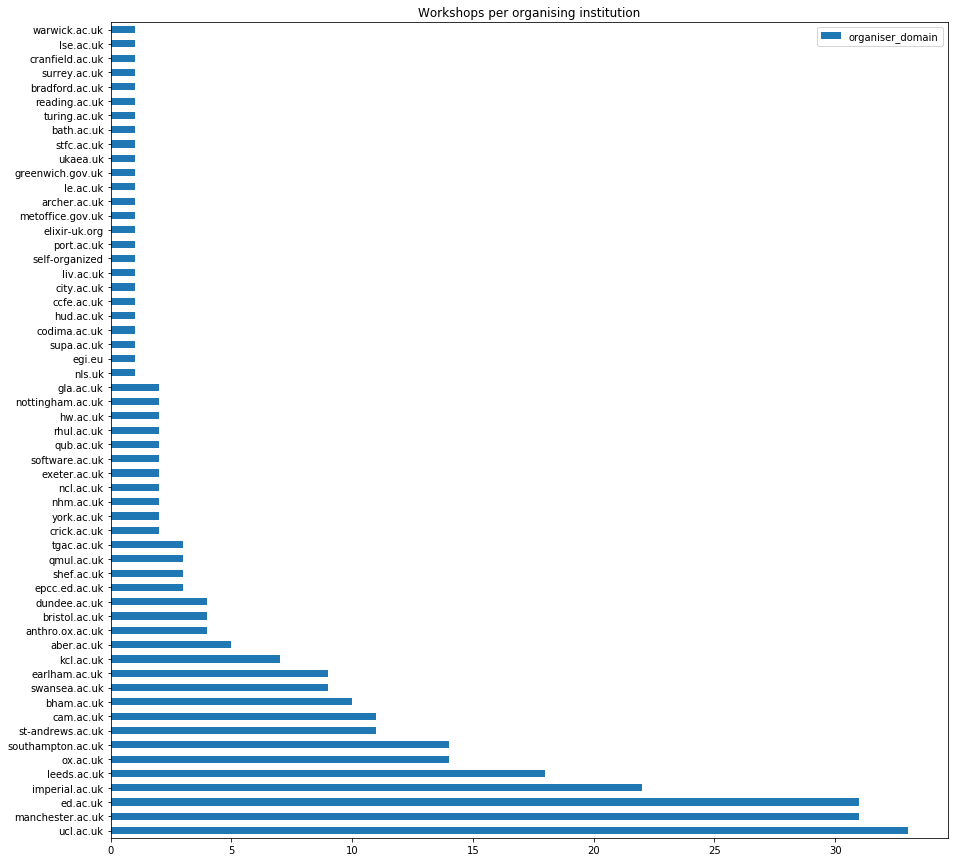

In [58]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['organiser_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per organising institution", figsize = (15,15))

Workshops with no region: 
Northern Ireland             2
North East                   3
East Midlands                6
South West                   8
West Midlands               11
Wales                       13
Eastern                     23
Yorkshire and The Humber    24
North West                  31
South East                  40
Scotland                    48
London                      71
Name: region, dtype: int64
Total number of workshops: 280


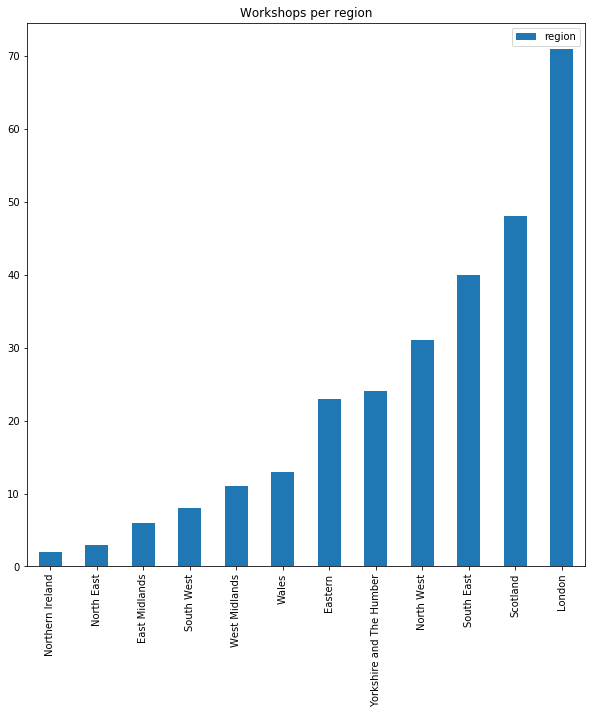

In [124]:
# How many workshops were held at each region?
print("Workshops with no region: ")
workshops_df[workshops_df['region']==""]

workshops_per_region = workshops_df['region'].value_counts().sort_values()
print(workshops_per_region)
total_no_workshops = workshops_per_region.sum()
print("Total number of workshops: " +str(total_no_workshops))
workshops_per_region.plot(kind='bar', legend=True, title ="Workshops per region", figsize = (10,10))

region
East Midlands                6
Eastern                     23
London                      71
North East                   3
North West                  31
Northern Ireland             2
Scotland                    48
South East                  40
South West                   8
Wales                       13
West Midlands               11
Yorkshire and The Humber    24
dtype: int64
workshop_type             Circuits  DC  LC  SWC  TTT  total
region                                                     
Northern Ireland                 0   1   0    1    0      2
North East                       1   0   0    2    0      3
East Midlands                    0   0   0    6    0      6
South West                       0   0   0    7    1      8
West Midlands                    0   0   0   11    0     11
Wales                            2   2   0    9    0     13
Eastern                          0  12   1    9    1     23
Yorkshire and The Humber         0   4   1   17    2     24
North We

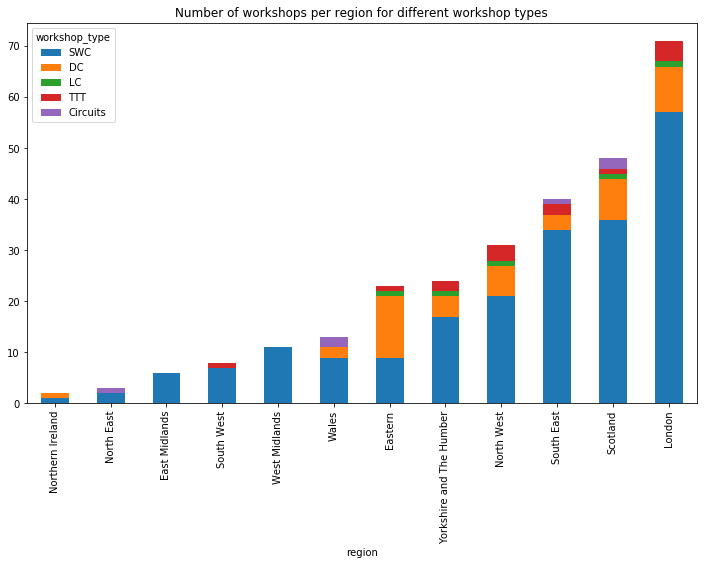

In [163]:
# How are numbers of different workshop types (SWC, DC, LC, TTT) looking per regions?
workshops_per_type_per_region = workshops_df.groupby(['workshop_type', 'region'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
print(workshops_per_type_per_region.sum(axis = 1, skipna = True))
workshops_per_type_per_region['total'] = workshops_per_type_per_region.sum(axis = 1, skipna = True)
workshops_per_type_per_region = workshops_per_type_per_region.sort_values(axis = 0, by=['total'])
workshops_per_type_per_region[WORKSHOP_TYPES].plot(kind='bar', stacked=True, title="Number of workshops per region for different workshop types", figsize = (12,7))
print(workshops_per_type_per_region)

Total number of workshops: 280
                                            region  workshop_count  \
region                                                               
Northern Ireland                  Northern Ireland               2   
North East                              North East               3   
East Midlands                        East Midlands               6   
South West                              South West               8   
West Midlands                        West Midlands              11   
Wales                                        Wales              13   
Eastern                                    Eastern              23   
Yorkshire and The Humber  Yorkshire and The Humber              24   
North West                              North West              31   
South East                              South East              40   
Scotland                                  Scotland              48   
London                                      London         

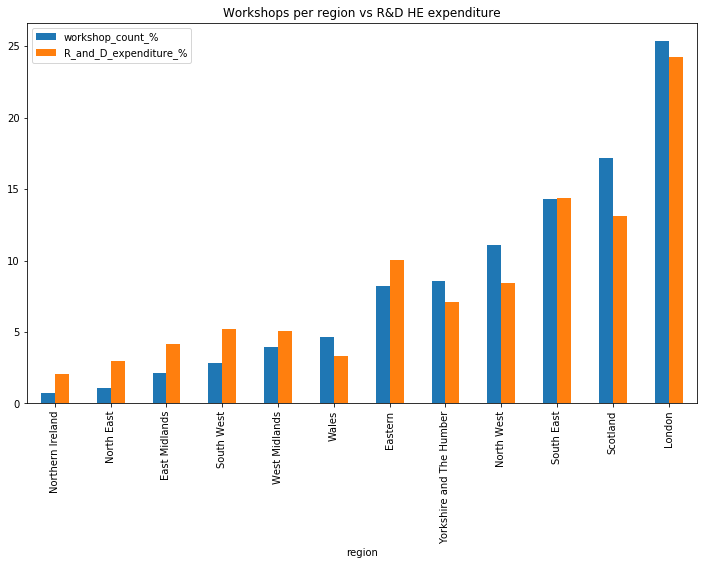

In [146]:
# Add R&D expenditure per region and let's plot that longside workshops per region to see how they match
R_and_D_expenditure = pd.read_csv(CURRENT_DIR +"/lib/R_and_D_expenditure-for-HE.csv", encoding = "utf-8")
R_and_D_expenditure_mapping = dict(R_and_D_expenditure[['Region','% of total R&D expenditure']].values)
workshops_per_region_df = pd.DataFrame()
workshops_per_region_df['region'] = workshops_per_region.index
workshops_per_region_df['workshop_count'] = workshops_per_region.index
workshops_per_region_df['workshop_count'] = workshops_per_region_df['workshop_count'].map(workshops_per_region)
workshops_per_region_df['R_and_D_expenditure_%'] = workshops_per_region_df['region'].map(R_and_D_expenditure_mapping)
total_no_workshops = workshops_per_region.sum()
workshops_per_region_df['workshop_count_%'] = (workshops_per_region_df['workshop_count']/total_no_workshops)*100
workshops_per_region_df.index = workshops_per_region_df['region']
print("Total number of workshops: " +str(total_no_workshops))
print(workshops_per_region_df)
workshops_per_region_df[['workshop_count_%', 'R_and_D_expenditure_%']].plot(kind='bar', legend=True, title ="Workshops per region vs R&D HE expenditure", figsize = (12,7))

year
2012     228
2013     439
2014     509
2015     898
2016     818
2017    1126
2018     830
2019     701
2020       0
Name: attendance, dtype: int64


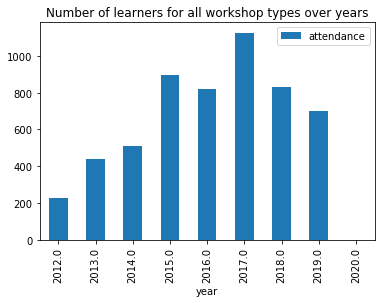

In [83]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

Average workshop attendance: 19

year
2012     228
2013     439
2014     509
2015     898
2016     818
2017    1126
2018     830
2019     701
2020       0
Name: attendance, dtype: int64


/Users/alex/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


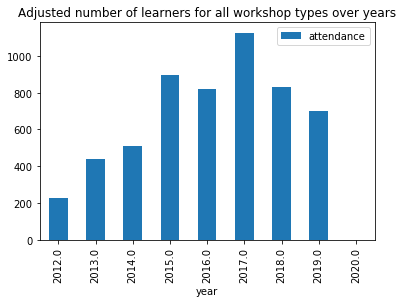

In [84]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

workshop_type
Circuits       0
DC           894
LC           164
SWC         4266
TTT          225
Name: attendance, dtype: int64


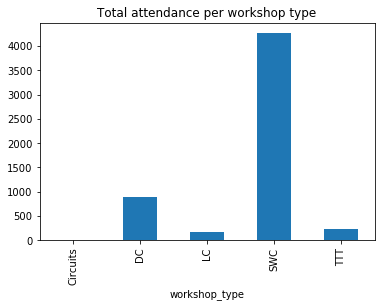

In [85]:
# Total attendance for different workshop types (with missing data adjusted with average attendance)
attendance_per_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
print(attendance_per_type)
attendance_per_type.plot(kind="bar", title="Total attendance per workshop type")

workshop_type  Circuits   DC  LC  SWC  TTT
year                                      
2012                  0    0   0  228    0
2013                  0    0   0  439    0
2014                  0    0   0  509    0
2015                  0   78  59  686   75
2016                  0  144   0  614   60
2017                  0  284  51  706   85
2018                  0  139  54  632    5
2019                  0  249   0  452    0
2020                  0    0   0    0    0


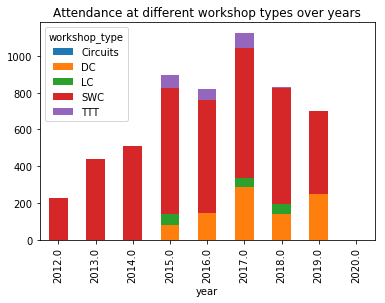

In [86]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")


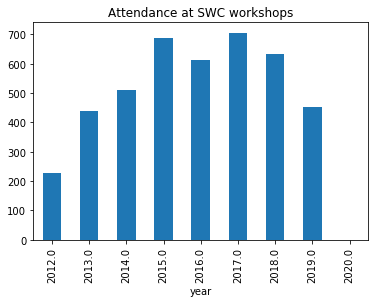

In [87]:
# Attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

In [ ]:
# How are workshops spread over UK regions? - plot workshops over UK regions
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [171]:
# Save all analyses into an Excel spreadsheet
ANALYSES_DIR = "data/analyses/"
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

workshops_df.to_excel(excel_writer, sheet_name=workshops_file_name, index=False)

# Write all tables we used for lookup
uk_academic_institutions.to_excel(excel_writer, sheet_name='uk_academic_institutions', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['uk_academic_institutions']
R_and_D_expenditure.to_excel(excel_writer, sheet_name='R_and_D_expenditure', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R_and_D_expenditure']

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshops per region
workshops_per_region.to_excel(excel_writer, sheet_name='workshops_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_region']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_region', 1, 0, len(workshops_per_region.index), 0],
        'values': ['workshops_per_region', 1, 1, len(workshops_per_region.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per region'})
worksheet.insert_chart('I2', chart)

# Workshops per type per region
workshops_per_type_per_region.to_excel(excel_writer, sheet_name='workshops_per_type_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_region']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_region[WORKSHOP_TYPES].columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_region', 0, i],
            'categories': ['workshops_per_type_per_region', i, 0, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), 0],
            'values': ['workshops_per_type_per_region', 1, i, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Region'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different type per region'})
worksheet.insert_chart('B20', chart)

# Workshop attendance per year
attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
        'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type
attendance_per_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_type', 1, 0, len(attendance_per_type.index), 0],
        'values': ['attendance_per_type', 1, 1, len(attendance_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per workshop type (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type per year
attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(attendance_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['attendance_per_type_per_year', 0, i],
            'categories': ['attendance_per_type_per_year', i, 0, len(attendance_per_type_per_year.index), 0],
            'values': ['attendance_per_type_per_year', 1, i, len(attendance_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Attendance at workshops of different types over years (with estimates for missing data)'})
worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)

Saved workshop analyses in data/analyses/analysed_workshops_UK_2020_02_18_from_ipynb.xlsx
